In [4]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import time
import xarray as xr
import mpl_toolkits as mpl
# import plotly.graph_objects as go
# import plotly.express as px
from scipy import interpolate
from matplotlib.pyplot import figure


### Idealized model to emulate the forest age after harvest rotation

#### 1. Mean age model with a single patch

In [ ]:
th_age = 35

class PrimaryForest:
    def __init__(self):
        self.age = 0
        self.area = 1.0
#         self.rotation_period = rotation_period

    def grow(self, years):
        for _ in range(years):
            self.age += 1

    def harvest_vh1(self, SecondaryForest, rate):
#         print("Harvesting the primary forest at age {"+str(self.age)+"} years, rate is ", rate)
        self.area = self.area * (1 - rate)
        SecondaryForest.area = SecondaryForest.area + self.area * rate

class SecondaryForest:
    def __init__(self):
        self.age = 0
        self.area = 0.0
#         self.rotation_period = rotation_period

    def grow(self, years):
        for _ in range(years):
            self.age += 1

    def harvest_sh1(self, rate):
        if(self.age >= th_age):
#             print("Harvesting the secondary forest at age {"+str(self.age)+"} years")
            self.age = self.age * (1 - rate)
        
    def harvest_sh2(self, rate):
#         print("Harvesting the secondary forest at age {"+str(self.age)+"} years")
        if(self.age < th_age):
            self.age = self.age * (1 - rate)

# Create a forest patch
pforest = PrimaryForest()
sforest = SecondaryForest()

# Grow the forest for 200 years
pforest.grow(years=200)

# Timeseries of harvest rate: 
hr_v1 = 0.1*np.ones((150))
hr_s1 = 0.1*np.ones((150))
hr_s2 = 0.1*np.ones((150))

page_rec = []
parea_rec = []
sage_rec = []
sarea_rec = []
# Do a simulation over 150 years
for i in np.arange(0,150):
    pforest.harvest_vh1(sforest, hr_v1[i])
    sforest.harvest_sh1(hr_s1[i])
    sforest.harvest_sh2(hr_s2[i])
    pforest.grow(years=1)
    sforest.grow(years=1)
    page_rec.append(pforest.age)
    parea_rec.append(pforest.area)
    sage_rec.append(sforest.age)
    sarea_rec.append(sforest.area)

In [ ]:
plt.plot(sage_rec)

In [ ]:
plt.plot(parea_rec)
plt.plot(sarea_rec)

#### 2. Age model with infinite patches

In [117]:
th_age = 35

class PrimaryForest:
    def __init__(self, new_area):
        self.age = 0
        self.area = new_area
#         self.rotation_period = rotation_period

    def grow(self, years):
        for _ in range(years):
            self.age += 1

    def harvest_vh1(self, rate):
#         print("Harvesting the primary forest at age {"+str(self.age)+"} years, rate is ", rate)
        secondary_forest = SecondaryForest(rate)
        self.area = self.area - rate
        return secondary_forest

class SecondaryForest:
    def __init__(self, new_area):
        self.age = 0
        self.area = new_area
#         self.rotation_period = rotation_period

    def grow(self, years):
        for _ in range(years):
            self.age += 1

    # Need to use the total secondary forest area (1 - parea) to scale the harvest rate
    def harvest_sh1(self, sarea_mat, rate):
#         print("Harvesting the secondary forest at age {"+str(self.age)+"} years")
        secondary_forest = SecondaryForest(rate * self.area / (sarea_mat + 1e-7))
        self.area = self.area - rate * self.area / (sarea_mat + 1e-7)
        return secondary_forest
        
    def harvest_sh2(self, sarea_yng, rate):
#         print("Harvesting the secondary forest at age {"+str(self.age)+"} years")
        secondary_forest = SecondaryForest(rate * self.area / (sarea_yng + 1e-7))
        self.area = self.area - rate * self.area / (sarea_yng + 1e-7)
        return secondary_forest
        
    def merge(self, SecondaryForest):
        if(self.age == SecondaryForest.age):
            self.area = self.area + SecondaryForest.area
            SecondaryForest.age = np.float('nan')
        
# Create the first forest patch
pforest = PrimaryForest(new_area=1.0)

# Grow the forest for 200 years
pforest.grow(years=200)
sforest_list = []

# Nyr and array to record history output
nyr = 150
sforest_age = []
sforest_area_ap = []
sforest_area = []
sforest_mat_area = []
sforest_yng_area = []
pforest_area = []
age_bin = np.arange(0,51)

# Timeseries of harvest rate: 
# hr_v1 = np.append((1.0/10.0)*np.ones((10)), np.zeros((nyr - 10)))
hr_v1 = np.append((1.0/35.0)*np.ones((35)), np.zeros((nyr - 35)))
hr_s1 = (1.0/35.0) * np.ones((nyr))
hr_s2 = np.zeros((nyr))

# Need to force the sume of hr_v1 to 1.0 if exceeds
if(np.nansum(hr_v1) > 1.0):
    hr_v1 = hr_v1 / (np.nansum(hr_v1) + 1e-7)

# Do a simulation over 150 years
for iyr in np.arange(0, nyr):
    # Harvest
    new_sforest_from_p = pforest.harvest_vh1(rate=hr_v1[iyr])
    new_sforest_from_s = []
    for sforest in sforest_list:
        if(sforest.age >= th_age):
            new_sforest_from_s.append(sforest.harvest_sh1(sarea_mat=sarea_mat, rate=hr_s1[iyr]))
        else:
            new_sforest_from_s.append(sforest.harvest_sh2(sarea_yng=sarea_yng, rate=hr_s2[iyr]))
    sforest_list.append(new_sforest_from_p)
    if(len(new_sforest_from_s) > 0):
        sforest_list.extend(new_sforest_from_s)
    # Merge all patches with the same age
    listlen = len(sforest_list)
    if (len(sforest_list) >= 2):
        for i in np.arange(0,listlen-1):
            for j in np.arange(i+1,listlen):
                sforest_list[i].merge(sforest_list[j])
        indices_to_remove = []
        for i in np.arange(0,listlen):
            if (np.isnan(sforest_list[i].age)):
                indices_to_remove.append(i)
        for i in sorted(indices_to_remove, reverse=True):
            del sforest_list[i]
    # Growth
    pforest.grow(years=1)
    for sforest in sforest_list:
        sforest.grow(years=1)
        
    # Obtain the total area of secondary mature and secondary young for
    # calculating the harvest for the next year
    sarea_mat = 0
    sarea_yng = 0
    for sforest in sforest_list:
        if(sforest.age >= th_age):
            sarea_mat = sarea_mat + sforest.area
        else:
            sarea_yng = sarea_yng + sforest.area

    # Output history    
    agg_sforest_area = 0.0
    agg_sforest_age = 0.0
    for sforest in sforest_list:
        agg_sforest_area = agg_sforest_area + sforest.area
    for sforest in sforest_list:
        agg_sforest_age = agg_sforest_age + sforest.age * sforest.area / (agg_sforest_area + 1e-7)
    pforest_area.append(pforest.area)
    sforest_area.append(agg_sforest_area)
    sforest_mat_area.append(sarea_mat)
    sforest_yng_area.append(sarea_yng)
    sforest_age.append(agg_sforest_age)
    
    # Use the pre-defined age-bin
    sf_area_ap = np.zeros((len(age_bin)-1))
    for sforest in sforest_list:
        for i in np.arange(0, len(sf_area_ap)):
            if (sforest.age > age_bin[i] and sforest.age <= age_bin[i+1]):
                sf_area_ap[i] = sf_area_ap[i] + sforest.area
    sforest_area_ap.append(sf_area_ap)

    #print('Passed one year. Current year is '+ str(iyr+1))

In [110]:
np.shape(sforest_area_ap)

(150L, 50L)

In [124]:
np.array(sforest_area_ap)[50,:]

array([2.85713286e-02, 2.85713286e-02, 2.85713286e-02, 2.85713286e-02,
       2.85713286e-02, 2.85713286e-02, 2.85713286e-02, 2.85713286e-02,
       2.85713286e-02, 2.85713286e-02, 2.85713286e-02, 2.85713286e-02,
       2.85713286e-02, 2.85713286e-02, 2.85713286e-02, 2.85713286e-02,
       2.85714286e-02, 2.85714286e-02, 2.85714286e-02, 2.85714286e-02,
       2.85714286e-02, 2.85714286e-02, 2.85714286e-02, 2.85714286e-02,
       2.85714286e-02, 2.85714286e-02, 2.85714286e-02, 2.85714286e-02,
       2.85714286e-02, 2.85714286e-02, 2.85714286e-02, 2.85714286e-02,
       2.85714286e-02, 2.85714286e-02, 2.85714286e-02, 1.59986841e-06,
       8.39866247e-11, 4.11504936e-15, 1.87222296e-19, 7.86285482e-24,
       3.02702959e-28, 1.05940659e-32, 3.33697893e-37, 9.34316496e-42,
       2.28899530e-46, 4.80674713e-51, 8.41160139e-56, 1.17760153e-60,
       1.23646429e-65, 8.65517431e-71])

In [105]:
fage = np.array(sforest_age[0:75])*np.array(sforest_area[0:75])

array([ 0.02857133,  0.08571414,  0.17142837,  0.28571404,  0.42857113,
        0.59999965,  0.7999996 ,  1.02857098,  1.28571379,  1.57142802,
        1.88571369,  2.22857078,  2.5999993 ,  2.99999925,  3.42857063,
        3.88571344,  4.37142767,  4.88571334,  5.42857043,  5.99999895,
        6.5999989 ,  7.22857028,  7.88571309,  8.57142732,  9.28571299,
       10.02857008, 10.7999986 , 11.59999855, 12.42856993, 13.28571274,
       14.17142697, 15.08571264, 16.02856973, 16.99999825, 17.9999982 ,
       18.0000017 , 18.0000051 , 18.0000084 , 18.0000116 , 18.0000147 ,
       18.0000177 , 18.0000206 , 18.0000234 , 18.0000261 , 18.0000287 ,
       18.0000312 , 18.0000336 , 18.0000359 , 18.0000381 , 18.0000402 ,
       18.0000422 , 18.0000441 , 18.0000459 , 18.0000476 , 18.0000492 ,
       18.0000507 , 18.0000521 , 18.0000534 , 18.0000546 , 18.0000557 ,
       18.0000567 , 18.0000576 , 18.0000584 , 18.0000591 , 18.0000597 ,
       18.0000602 , 18.0000606 , 18.0000609 , 18.0000611 , 18.00

Text(0,0.5,'mean age')

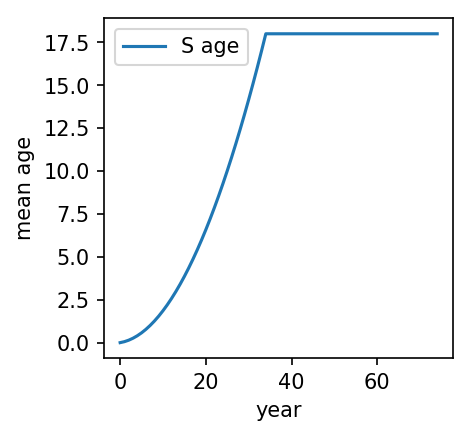

In [108]:
# Make plots
figure(figsize=(3, 3), dpi=150)
plt.plot((sforest_age[0:75])*np.array(sforest_area[0:75]))
plt.legend(['S age'])
plt.xlabel('year')
plt.ylabel('mean age')

Text(0,0.5,'Fractional area')

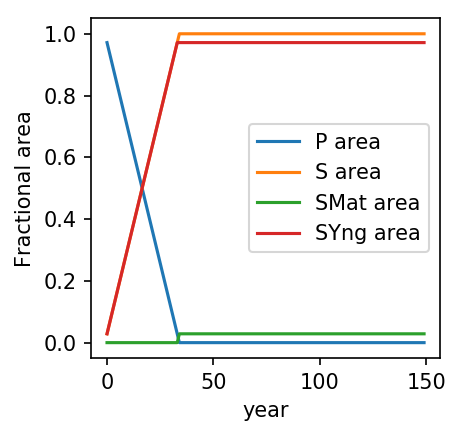

In [53]:
figure(figsize=(3, 3), dpi=150)
plt.plot(pforest_area)
plt.plot(sforest_area)
plt.plot(sforest_mat_area)
plt.plot(sforest_yng_area)
# plt.plot(np.array(pforest_area)+np.array(sforest_area))
plt.legend(['P area', 'S area', 'SMat area', 'SYng area'])
plt.xlabel('year')
plt.ylabel('Fractional area')

Text(0,0.5,'Fractional area')

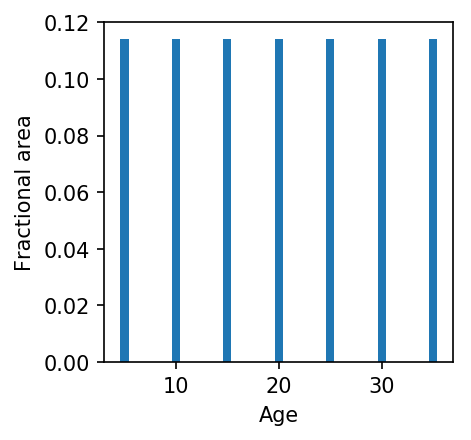

In [86]:
### histogram of the age
figure(figsize=(3, 3), dpi=150)
plt.bar(age_bin[1:8], sforest_area_ap[149])
plt.xlabel('Age')
plt.ylabel('Fractional area')